In [12]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp
import mpmath 

In [13]:
@element(num_params=6,units=["","","","","",""],overwrite=True)
def arbitRCPE(p,f):
    Q, alpha, R1, R2, R3,R4 = p[0], p[1], p[2], p[3], p[4], p[5]
    x1 = np.array([0,0.12,0.3,1])
    # y = np.array([500,400,300,100])
    y1 = np.array([R1,R2,R3,R4])
    def R(xpoint):
        # return a/(1+b*x)
        # return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
        # return Akima1DInterpolator(x1, y1)(xpoint)
        return np.interp(xpoint,x1,y1)
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1
    return Z_list

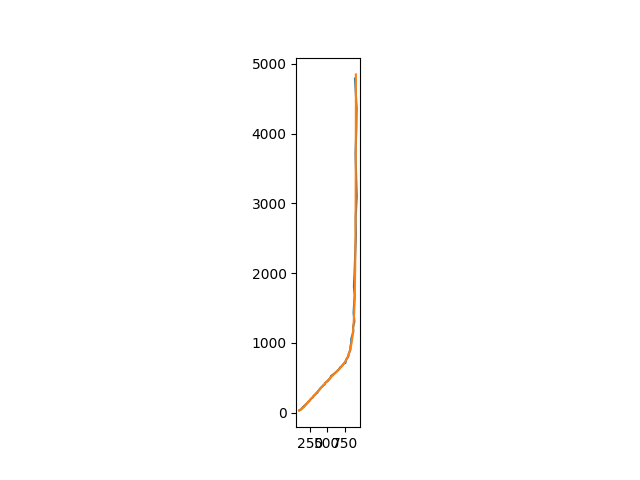

In [14]:
freq_list=np.logspace(-1,3,100)
#parameter for the TLM
Q_dt=6.61e-4
alpha_dt=1

R1_dt=1000
delta1_dt=0.12
R2_dt=2000
delta2_dt=0.17
R3_dt=2.15*194.5


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

cmodel=CustomCircuit(initial_guess=[R1_dt,R1_dt*Q_dt,R2_dt*Q_dt,alpha_dt,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlinnew_1-R_1-p(R_2,CPE_1)")
mp.dps=300
zexp=cmodel.predict(frequencies=freq_list)
zexp_noise=np.real(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.real(zexp)+(np.imag(zexp)+np.random.normal(0,0.01,(len(zexp)))*np.imag(zexp))*1j
fig, ax =plt.subplots()
# ax.plot([0,delta1,delta1,1],[R1,R1,R2,R2])
ax.plot(np.real(zexp_noise),-np.imag(zexp_noise))
ax.plot(np.real(zexp),-np.imag(zexp))
ax.set_aspect("equal")

In [24]:
#initial guesses for the TLM
#Double layer Capacitance inside porous electrode
Q=6.61e-4
alpha=1

R1=400
delta1=0.3
R2=400

R3=400
delta2=0.3

#arbit
R4=500

#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=200
Rrxn=200
Qdl=6.61e-4
alpha2=1

#other (for arbitrary tortuosity profile)
Rref=200
a=4
b=5

cmodel1=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

cmodel3=CustomCircuit(initial_guess=[Q,alpha,R1,R2,R3,R4,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitRCPE_1-R_1-p(R_2,CPE_1)")

cmodel4=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")


In [34]:
#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

cmodel1.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,1)])

cmodel2.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,1)])

cmodel3.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,""),bounds=[(0,0,0,0,0,0,0,0,0,0.5),(np.inf,1,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1)])

# mp.dps=700
# cmodel4.fit(impedance=zexp_noise,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0.5,0,0,0,0.5),(np.inf,np.inf,np.inf,1,np.inf,np.inf,np.inf,1)])

zfit1=cmodel1.predict(frequencies=freq_list)
delta1_fit1=cmodel1.parameters_[3]
R1_fit1=cmodel1.parameters_[0]
R2_fit1=cmodel1.parameters_[2]*cmodel1.parameters_[0]/cmodel1.parameters_[1]

zfit2=cmodel2.predict(frequencies=freq_list)
delta1_fit2=cmodel2.parameters_[4]
delta2_fit2=cmodel2.parameters_[5]
R1_fit2=cmodel2.parameters_[0]
R2_fit2=cmodel2.parameters_[2]*cmodel2.parameters_[0]/cmodel2.parameters_[1]
R3_fit2=cmodel2.parameters_[3]*cmodel2.parameters_[0]/cmodel2.parameters_[1]

zfit3=cmodel3.predict(frequencies=freq_list)
R1_fit3=cmodel3.parameters_[2]
R2_fit3=cmodel3.parameters_[3]
R3_fit3=cmodel3.parameters_[4]
R4_fit3=cmodel3.parameters_[5]

# zfit4=cmodel4.predict(frequencies=freq_list)
# R1_fit4=cmodel4.parameters_[2]
# R2_fit4=cmodel4.parameters_[3]
# R3_fit4=cmodel4.parameters_[4]
# R4_fit4=cmodel4.parameters_[5]

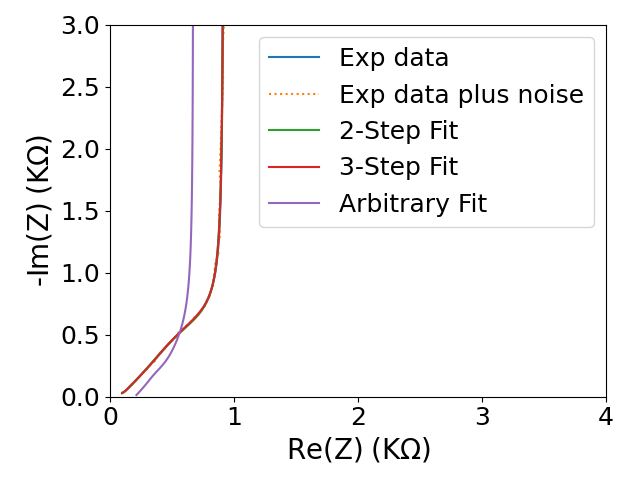

In [32]:
# fig1, ax1 =plt.subplots()
# ax1.plot(np.real(zexp),-np.imag(zexp),label="Exp data")
# ax1.plot(np.real(zexp_noise),-np.imag(zexp_noise),label="Exp data plus noise")
# ax1.plot(np.real(zfit),-np.imag(zfit),label="Fit")
# ax1.legend()
# ax1.set_aspect("equal")

fig1, ax1 =plt.subplots()
ax1.plot(np.real(zexp)/1000,-np.imag(zexp)/1000,label="Exp data")
ax1.plot(np.real(zexp_noise)/1000,-np.imag(zexp_noise)/1000,":",label="Exp data plus noise")
ax1.plot(np.real(zfit1)/1000,-np.imag(zfit1)/1000,label="2-Step Fit")
ax1.plot(np.real(zfit2)/1000,-np.imag(zfit2)/1000,label="3-Step Fit")
ax1.plot(np.real(zfit3)/1000,-np.imag(zfit3)/1000,label="Arbitrary Fit")
ax1.legend(fontsize=18)
ax1.set_xlabel("Re(Z)$\;($K$\Omega$)",fontsize=20)
ax1.set_ylabel("-Im(Z)$\;($K$\Omega$)",fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(0,4)
ax1.set_ylim(0,3)
ax1.set_aspect("equal")
plt.tight_layout()
fig1.savefig("Nyq_2stepnoise.png",dpi=700)

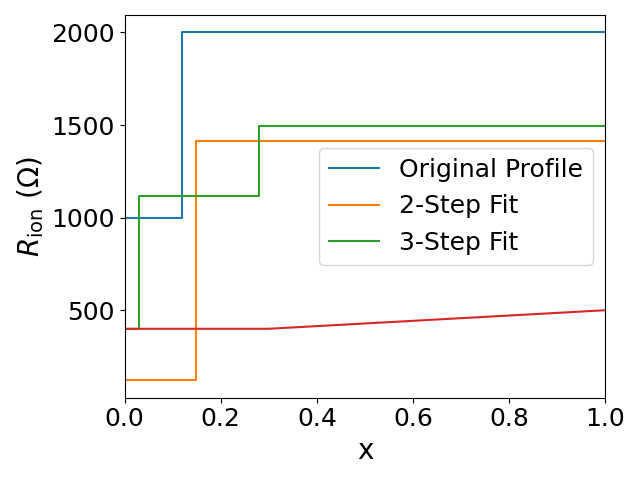

In [33]:
fig2, ax2= plt.subplots()
ax2.plot([0,delta1_dt,delta1_dt,1],[R1_dt,R1_dt,R2_dt,R2_dt],label="Original Profile")
ax2.plot([0,delta1_fit1,delta1_fit1,1],[R1_fit1,R1_fit1,R2_fit1,R2_fit1],label="2-Step Fit")
# ax2.plot([0,delta1_fit2,delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2])

ax2.plot([0,delta1_fit2,delta1_fit2,delta2_fit2+delta1_fit2,delta2_fit2+delta1_fit2,1],[R1_fit2,R1_fit2,R2_fit2,R2_fit2,R3_fit2,R3_fit2],label="3-Step Fit")

ax2.plot([0,0.12,0.3,1],[R1_fit3,R2_fit3,R3_fit3,R4_fit3])
ax2.legend(fontsize=18)
ax2.set_xmargin(0)
ax2.set_xlabel("x",fontsize=20)
ax2.set_ylabel("$R_{\mathrm{ion}}$ $(\Omega)$",fontsize=20)
ax2.tick_params(labelsize=18)
plt.tight_layout()
fig2.savefig("2stepnoise.png",dpi=700)